# Environments

## Why?

Environments allow DAGs to easily switch configuration parameters. These happens for three reasons primarily.

### 1. Allow team members to use the same DAG definition but run in isolated environments

If a DAG is developed by more than one person, you don't want others to accidentally write your files or tables. Ideally, each member should have a completely isolated environment (e.g. users write to their own `/data/{{user}}` folder in the shared server and `{{user}}` schema in the database), but if this is not possible for data scale reasons, there could be overlapping environments.

### 2. Let multiple runs from the same pipeline co-exist

It is a good practice to always have a working version of your code, this is usually done by using a VCS such as git by keeping working code in the `master` branch. Say you finished building your DAG from the `master` banch and now you want to work on a new feature in a `dev` branch, if you switch branches and start making code changes, calling `dag.build()` will overwrite your results, to prevent this from happening you could have one copy for each branch, this way you can work on `dev` and always have a working up-to-date pipeline run for the code stored in `master`.

### 3. Switch between production and development environments


An environment can be started either by passing a dictionary or a path to a YAML file, `Env` also implements a rendering logic where placeholders are resolved, this allows a single DAG definition to switch configuration automatically. Let's implement use case (1) to allow team members have their own environments

In [1]:
import os
import shutil
from pathlib import Path
import tempfile

import pandas as pd
from IPython.display import display, Markdown

from ploomber import DAG
from ploomber import Env, with_env
from ploomber.tasks import PythonCallable
from ploomber.products import File

In [2]:
env = Env.start({'path': {'data': '/data/{{user}}'}, 'db': {'uri': 'DB_URI', 'schema': '{{user.lower()}}'}})
print(env)
Env.end()

## Integrating Env and DAG

In the previous example, we started and ended and Env manually, to automatically manage the Env lifecycle, the "factory" pattern is introduced.

### Factory pattern

The factory pattern (do not confuse with the pattern in [OOP](https://en.wikipedia.org/wiki/Factory_method_pattern) is simply to have functions return DAG instances:

In [3]:
def make():
    """Simplest factory possible
    """
    return DAG()

Using the factory pattern makes easy to restrict an Env's life to the body of the function using the `@with_env` decorator.

In [4]:
@with_env({'path': {'data': '/data/{{user}}'}})
def make(env):
    """Simplest factory possible
    """
    print('Env is:', env)
    return DAG()

dag = make()

Env is: <ploomber.env.EnvDict.EnvDict object at 0x12318fbe0>


By coding DAGs this way we can have a single DAG definition whose configuration is automatically resolved at declaration time (inside the function), hence, if someone else calls this function, their environment will be resolved to their corresponding data folder.

Note that we called `make()` without arguments, that's because the decorator injects the environment automatically.

## Using the `{{git}}` placeholder for environment isolation


`{{git}}` allows you to switch configuration depending on the your project's revision. But before resolving its value, `Env` has to resolve your project's module path (call it `MODULE_PATH`). In order to do that, you need to provide the `_module` key. Assuming your env is `{'_module: MODULE_VALUE'}` processing goes as follows:

First, try to locate a module named `MODULE_VALUE` (similar to what `import MODULE_VALUE` would do but without actually importing the module), if found, the module's location is your `MODULE_PATH`, if no module is found with such name, interpret `MODULE_VALUE` directly as `MODULE_PATH`.

Once `MODULE_PATH` is determined, `{{git}}` will assume there is a git repository in `MODULE_PATH` and return the branch name if you are at the latest commit, otherwise it will return the git hash. This will allow you to keep isolated pipeline runs, one per branch. Furthermore, if you move to a specific commit and run your pipeline this will prevent overwriting your current working code.

In [5]:
# hide setup
tmp_dir = tempfile.mkdtemp()
tmp_dir_path = Path(tmp_dir)
# print("Temporary project's root folder: ", tmp_dir)
os.chdir(tmp_dir)

In [6]:
# create a sample repository
! git init
# add first commit
! touch a_file.py
! git add --all
! git commit -m 'first commit'
! touch another_file.py
! git add --all
! git commit -m 'second commit'

Initialized empty Git repository in /private/var/folders/3h/_lvh_w_x5g30rrjzb_xnn2j80000gq/T/tmpkcp4ku79/.git/
[master (root-commit) cae198c] first commit
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 a_file.py
[master acded30] second commit
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 another_file.py


In [7]:
# we are at the tip of the master branch
Env.start({'_module': tmp_dir, 'path': {'data': '/data/{{git}}'}})
print('env.path.data:', env.path.data)
Env.end()

env.path.data: /data/master


In [8]:
! git checkout -b dev

Switched to a new branch 'dev'


In [9]:
# we are at the tip of the dev branch
Env.start({'_module': tmp_dir, 'path': {'data': '/data/{{git}}'}})
print('env.path.data:', env.path.data)
Env.end()

env.path.data: /data/dev


In [10]:
! git checkout HEAD~1

Note: switching to 'HEAD~1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at cae198c first commit


In [11]:
# we moved to a specific commit
Env.start({'_module': tmp_dir, 'path': {'data': '/data/{{git}}'}})
print('env.path.data:', env.path.data)
Env.end()

env.path.data: /data/cae198c


In [12]:
# hide this
! git checkout dev

Previous HEAD position was cae198c first commit
Switched to branch 'dev'


## Loading environments from YAML files

In the previous examples, we've been coding our configuration directly as a dictionary, however, for a real project we want to keep configuration and code separate. Env also accepts paths to YAML as arguments:

In [13]:
env_yaml = """
path:
    data: '/data/{{user}}'

db:
    uri: 'DB_URI'
    schema: '{{user.lower()}}'
"""

(tmp_dir_path / 'env.yaml').write_text(env_yaml)

def display_file(file, syntax):
    s = """
```{}
{}
```
""".format(syntax, file)
    return display(Markdown(s))

In [14]:
display_file(env_yaml, 'yaml')


```yaml

path:
    data: '/data/{{user}}'

db:
    uri: 'DB_URI'
    schema: '{{user.lower()}}'

```


In [15]:
env = Env.start()
print('Env: ', env)
Env.end()

Env:  <ploomber.env.EnvDict.EnvDict object at 0x1268244a8>


## What goes in? What leave out?

## Putting everything together

In [25]:
# hide this
code = """
# Content of main.py

from ploomber import DAG, with_env
from ploomber.tasks import PythonCallable
from ploomber.products import File

import pandas as pd
from sklearn.datasets import load_wine


@with_env
def make(env):
    \"\"\"DAG factory
    \"\"\"
    env.path.data.mkdir(parents=True, exist_ok=True)

    dag = DAG(name='my pipeline')

    get = PythonCallable(_get,
                         product=File(env.path.data / 'data.csv'),
                         dag=dag,
                         name='data')
    
    transform = PythonCallable(_transform,
                               product=File(env.path.data / 'transformed.csv'),
                               dag=dag,
                               name='transform')
    
    get >> transform
    
    return dag


def _get(product):
    \"\"\"Get data
    \"\"\"
    wine = load_wine()
    df = pd.DataFrame(wine.data)
    df['target'] = wine.target
    df.to_csv(str(product))

def _transform(upstream, product):
    \"\"\"Transform data
    \"\"\"
    df = pd.read_csv(str(upstream['data']))
    df['new_column'] = 42
    df.to_csv(str(product))
"""

env = """
# Content of env.yaml

_module: '{{here}}'

path:
    data: '{{here}}/data/{{user}}/{{git}}/'
"""

Path('main.py').write_text(code)
Path('env.yaml').write_text(env)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Edu/miniconda3/envs/ploomber/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-0002229e59fa>", line 61, in <module>
    Path('main.py').write_text(code)
  File "/Users/Edu/miniconda3/envs/ploomber/lib/python3.6/pathlib.py", line 1215, in write_text
    with self.open(mode='w', encoding=encoding, errors=errors) as f:
  File "/Users/Edu/miniconda3/envs/ploomber/lib/python3.6/pathlib.py", line 1183, in open
    opener=self._opener)
  File "/Users/Edu/miniconda3/envs/ploomber/lib/python3.6/pathlib.py", line 1037, in _opener
    return self._accessor.open(self, flags, mode)
  File "/Users/Edu/miniconda3/envs/ploomber/lib/python3.6/pathlib.py", line 387, in wrapped
    return strfunc(str(pathobj), *args)
FileNotFoundError: [Errno 2] No such file or directory: 'main.py'

During handling of the above exception, another exception o

FileNotFoundError: [Errno 2] No such file or directory: 'main.py'

### Content of `main.py`

In [17]:
display_file(code, 'python')


```python

# Content of main.py

from ploomber import DAG, with_env
from ploomber.tasks import PythonCallable
from ploomber.products import File

import pandas as pd
from sklearn.datasets import load_wine


@with_env
def make(env):
    """DAG factory
    """
    env.path.data.mkdir(parents=True, exist_ok=True)

    dag = DAG(name='my pipeline')

    get = PythonCallable(_get,
                         product=File(env.path.data / 'data.csv'),
                         dag=dag,
                         name='data')
    
    transform = PythonCallable(_transform,
                               product=File(env.path.data / 'transformed.csv'),
                               dag=dag,
                               name='transform')
    
    get >> transform
    
    return dag


def _get(product):
    """Get data
    """
    wine = load_wine()
    df = pd.DataFrame(wine.data)
    df['target'] = wine.target
    df.to_csv(str(product))

def _transform(upstream, product):
    """Transform data
    """
    df = pd.read_csv(str(upstream['data']))
    df['new_column'] = 42
    df.to_csv(str(product))

```


### Content of `env.yaml`

In [24]:
display_file(env, 'yaml')


```yaml

# Content of env.yaml

_module: '{{here}}'

path:
    data: '{{here}}/data/{{user}}/{{git}}/'

```


In [19]:
import main
# TODO: why is the fatal: ref HEAD is not a symbolic ref
# message showing up

In [20]:
dag = main.make()
dag.status()

name,Last updated,Outdated dependencies,Outdated code,Product,Doc (short),Location
data,Has not been run,False,True,/private/var/folders/3h/_lvh_w_x5g30rrjzb_xnn2j80000gq/T/tmpkcp4ku79/data/Edu/dev/data.csv,Get data,/private/var/folders/3h/_lvh_w_x5g30rrjzb_xnn2j80000gq/T/tmpkcp4ku79/main.py:35
transform,Has not been run,True,True,/private/var/folders/3h/_lvh_w_x5g30rrjzb_xnn2j80000gq/T/tmpkcp4ku79/data/Edu/dev/transformed.csv,Transform data,/private/var/folders/3h/_lvh_w_x5g30rrjzb_xnn2j80000gq/T/tmpkcp4ku79/main.py:43


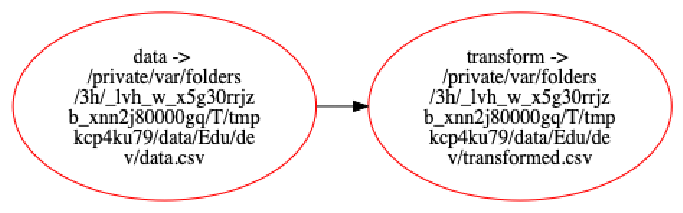

In [21]:
_ = dag.plot(output='matplotlib')

In [22]:
dag.build(force=True)

name,Ran?,Elapsed (s),Percentage
data,True,0.118587,50.1243
transform,True,0.117999,49.8757


In [23]:
# cleanup setup
shutil.rmtree(tmp_dir)